In [13]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from loguru import logger

logger.remove()
logger.add(f"./log/xgboost.log", format="{time} {level} {message}", mode='w')
logger.info("Start running xgboost model")

In [14]:
import pickle

data = pickle.load(open('./data/data.pkl', 'rb'))

X, y, date_mask = data['X'], data['y'], data['date_mask']

logger.info(f"Shape of X, y, date_mask: {X.shape, y.shape, date_mask.shape}")

In [15]:
span = 1
u = 365

results = []
for i in tqdm(range(0, 211 // span)):
    X_train = X[(date_mask >= 0 + (i-u)*span) & (date_mask < 0 + i*span)]
    # X_train = X[(date_mask < 0 + i*span)]
    X_test = X[(date_mask >= 0 + i*span) & (date_mask < 0 + (i+1)*span)]
    y_train = y[(date_mask >= 0 + (i-u)*span) & (date_mask < 0 + i*span)]
    # y_train = y[(date_mask < 0 + i*span)]
    y_test = y[(date_mask >= 0 + i*span) & (date_mask < 0 + (i+1)*span)]
    
    logger.info(f"Training for period {i*span} to {(i+1)*span}")
    
    model = xgb.XGBClassifier()  # 创建一个 XGBoost 分类器
    model.fit(X_train.reshape(X_train.shape[0], -1), y_train.reshape(-1, 1))
    
    predictions = model.predict(X_test.reshape(X_test.shape[0], -1))
    
    y_pred_proba = model.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    logger.info(f"Accuracy: {accuracy_score(y_test, predictions)} ROC_AUC: {roc_auc}")
    
    results.append({'roc_auc': roc_auc, 'acc': accuracy_score(y_test, predictions), 'date': i})
    # break

100%|██████████| 211/211 [01:17<00:00,  2.73it/s]


In [16]:
human = pd.read_csv('./log/human.csv', index_col=0)

human

,created_day,ticker_f,user.id,label,prc,prc_next1,ret_next1,up_next1,prc_next7,ret_next7,...,Revenue_ps,Capital_reserve_ps,Quick_ratio,Inventory_t,Fixed_asset_t,Current_asset_t,Operating_cycle,NAVPS,google_count,similarity_gme
0,2020-10-01,A,1.279806e+06,0.500000,101.22,100.01,0.988046,0.0,104.160,1.029046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.187435
1,2020-10-01,AAL,2.187015e+06,0.607118,12.58,13.00,1.033386,1.0,13.155,1.045707,...,23.22,10.68,0.65,2.81,0.35,1.15,129.14,-10.87,NaN,0.501470
2,2020-10-01,AAPL,2.204455e+06,0.795234,116.79,113.02,0.967720,0.0,114.970,0.984416,...,16.01,11.12,0.97,1.23,0.33,0.61,168.62,-11.84,NaN,0.581615
3,2020-10-01,ABB,1.867333e+06,1.000000,25.64,25.89,1.009750,1.0,26.540,1.035101,...,22.27,11.12,1.02,40.03,9.60,2.63,29.86,3.84,NaN,0.179303
4,2020-10-01,ABBV,1.382634e+06,1.000000,87.14,86.12,0.988295,0.0,87.340,1.002295,...,18.10,9.71,0.81,4.05,8.04,0.88,125.19,8.65,NaN,0.324576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130198,2021-10-26,XLNX,2.104853e+06,0.935484,171.88,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.239678
130199,2021-10-26,XOM,2.879285e+06,0.907520,65.84,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.327221
130200,2021-10-26,YUM,2.353407e+06,0.833333,126.18,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.309773
130201,2021-10-26,ZBH,5.260572e+06,1.000000,149.83,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300199


In [17]:
human = pd.read_csv('./log/human.csv', index_col=0)

human['created_day'] = pd.to_datetime(human['created_day'])

human = human.groupby('created_day').agg({'perf_next30': 'mean'})

human.reset_index(inplace=True)

human = human[human.created_day.isin(pd.date_range('2020-10-01', '2021-04-30'))]

human.rename(columns={'created_day': 'day', 'perf_next30': 'y'}, inplace=True)

human

,day,y
0,2020-10-01,0.394203
1,2020-10-02,0.384542
2,2020-10-03,0.440587
3,2020-10-04,0.502430
4,2020-10-05,0.510213
...,...,...
207,2021-04-26,0.560350
208,2021-04-27,0.571396
209,2021-04-28,0.614894
210,2021-04-29,0.578982


In [18]:
df_xgb = pd.DataFrame(results, index=pd.date_range(start='2020-10-01', end='2021-04-29'))

df_xgb.reset_index(inplace=True)

df_xgb.columns = ['day', 'roc_auc', 'acc', 'date']

df_xgb

,day,roc_auc,acc,date
0,2020-10-01,0.807453,0.606452,0
1,2020-10-02,0.773436,0.708155,1
2,2020-10-03,0.817422,0.744635,2
3,2020-10-04,0.843178,0.770386,3
4,2020-10-05,0.775818,0.703863,4
...,...,...,...,...
206,2021-04-25,0.848464,0.824034,206
207,2021-04-26,0.796011,0.817597,207
208,2021-04-27,0.779481,0.804721,208
209,2021-04-28,0.706694,0.781116,209


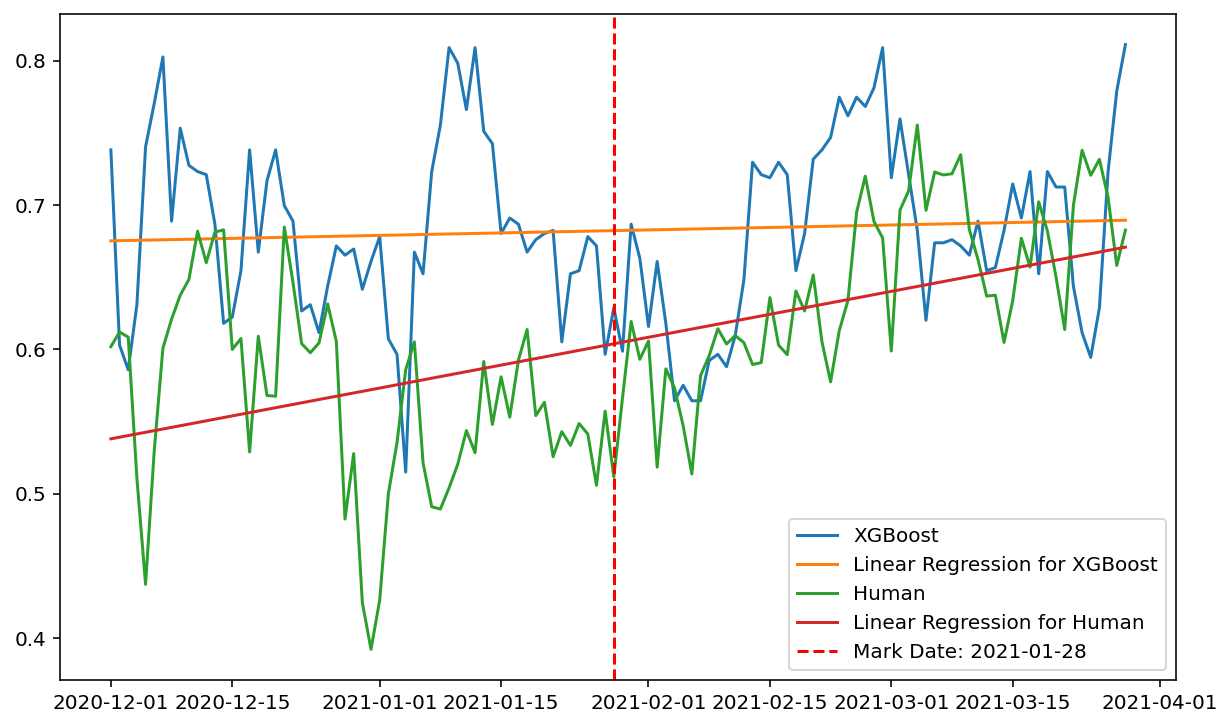

In [19]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

new = df_xgb.merge(
    human,
    on=['day'],
    how='left'
)

new = new[new.day.isin(pd.date_range('20201201', '20210328'))]

reg_acc = LinearRegression().fit(np.arange(len(new.day)).reshape(-1, 1), new.acc)
acc_pred = reg_acc.predict(np.arange(len(new.day)).reshape(-1, 1))

reg_y = LinearRegression().fit(np.arange(len(new.day)).reshape(-1, 1), new.y)
y_pred = reg_y.predict(np.arange(len(new.day)).reshape(-1, 1))


plt.figure(figsize=(10, 6), dpi=144)

plt.plot(new.day, new.acc, label='XGBoost')
plt.plot(new.day, acc_pred, label='Linear Regression for XGBoost')
plt.plot(new.day, new.y, label='Human')
plt.plot(new.day, y_pred, label='Linear Regression for Human')

plt.axvline(x=pd.Timestamp('2021-01-28'), color='r', linestyle='--', label='Mark Date: 2021-01-28')

plt.legend()
plt.savefig('./log/xgboost.png')